In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras import losses
from keras.callbacks import TensorBoard
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
import keras.backend as K
import scipy
import logging
import matplotlib.pyplot as plt
import os
from utils import *
from kh_tools import *
import numpy as np

Using TensorFlow backend.


In [2]:
import os
import datetime
import json
from PIL import Image
import numpy as np
from glob import glob
from PIL import Image, ImageDraw
from scipy import ndimage, misc
import scipy.misc
import imageio

from skimage.util import random_noise
def get_noisy_data(data):
    lst_noisy = []
    sigma = 0.155
    for image in data:
        noisy = random_noise(image, var=sigma ** 2)
        lst_noisy.append(noisy)
    return np.array(lst_noisy)


discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
d_h0_conv (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
d_h1_conv (Conv2D)           (None, 7, 7, 32)          12832     
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 32)          0         
_________________________________________________________________
d_h2_conv (Conv2D)           (None, 4, 4, 64)          51264 

Epoch:[0]-[31/52] --> d_loss: 1.839, total_g_loss:0.993, lr_loss:0.211, g_loss:0.950
Epoch:[0]-[32/52] --> d_loss: 1.832, total_g_loss:0.998, lr_loss:0.132, g_loss:0.972
Epoch:[0]-[33/52] --> d_loss: 1.837, total_g_loss:0.980, lr_loss:0.301, g_loss:0.920
Epoch:[0]-[34/52] --> d_loss: 1.860, total_g_loss:0.949, lr_loss:0.191, g_loss:0.911
Epoch:[0]-[35/52] --> d_loss: 1.898, total_g_loss:0.967, lr_loss:0.251, g_loss:0.917
Epoch:[0]-[36/52] --> d_loss: 1.837, total_g_loss:1.058, lr_loss:0.152, g_loss:1.027
Epoch:[0]-[37/52] --> d_loss: 1.918, total_g_loss:0.941, lr_loss:0.124, g_loss:0.916
Epoch:[0]-[38/52] --> d_loss: 1.872, total_g_loss:0.942, lr_loss:0.099, g_loss:0.922
Epoch:[0]-[39/52] --> d_loss: 1.762, total_g_loss:0.946, lr_loss:0.101, g_loss:0.926
Epoch:[0]-[40/52] --> d_loss: 1.693, total_g_loss:0.901, lr_loss:0.106, g_loss:0.880
Epoch:[0]-[41/52] --> d_loss: 1.932, total_g_loss:0.953, lr_loss:0.150, g_loss:0.923
Epoch:[0]-[42/52] --> d_loss: 1.805, total_g_loss:0.942, lr_loss:

Epoch:[2]-[23/52] --> d_loss: 1.642, total_g_loss:0.800, lr_loss:0.098, g_loss:0.780
Epoch:[2]-[24/52] --> d_loss: 1.610, total_g_loss:0.782, lr_loss:0.083, g_loss:0.765
Epoch:[2]-[25/52] --> d_loss: 1.608, total_g_loss:0.789, lr_loss:0.080, g_loss:0.773
Epoch:[2]-[26/52] --> d_loss: 1.627, total_g_loss:0.810, lr_loss:0.096, g_loss:0.790
Epoch:[2]-[27/52] --> d_loss: 1.593, total_g_loss:0.825, lr_loss:0.086, g_loss:0.808
Epoch:[2]-[28/52] --> d_loss: 1.585, total_g_loss:0.777, lr_loss:0.230, g_loss:0.731
Epoch:[2]-[29/52] --> d_loss: 1.666, total_g_loss:0.903, lr_loss:0.126, g_loss:0.878
Epoch:[2]-[30/52] --> d_loss: 1.673, total_g_loss:0.852, lr_loss:0.103, g_loss:0.831
Epoch:[2]-[31/52] --> d_loss: 1.615, total_g_loss:0.813, lr_loss:0.088, g_loss:0.795
Epoch:[2]-[32/52] --> d_loss: 1.576, total_g_loss:0.760, lr_loss:0.096, g_loss:0.741
Epoch:[2]-[33/52] --> d_loss: 1.694, total_g_loss:0.784, lr_loss:0.138, g_loss:0.757
Epoch:[2]-[34/52] --> d_loss: 1.650, total_g_loss:0.795, lr_loss:

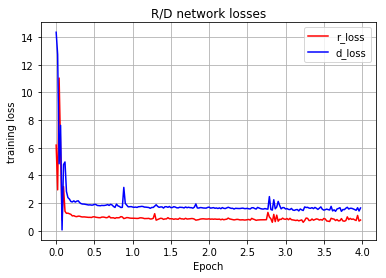

In [4]:
class ALOCC_Model():
    def __init__(self,
               input_height=28,input_width=28, output_height=28, output_width=28,
               attention_label=1, is_training=True,
               z_dim=100, gf_dim=16, df_dim=16, c_dim=3,
               dataset_name=None, dataset_address=None, input_fname_pattern=None,
               checkpoint_dir='checkpoint', log_dir='log', sample_dir='sample', r_alpha = 0.2,
               kb_work_on_patch=True, nd_patch_size=(10, 10), n_stride=1,
               n_fetch_data=10):

        self.b_work_on_patch = kb_work_on_patch
        self.sample_dir = sample_dir

        self.is_training = is_training

        self.r_alpha = r_alpha

        self.input_height = input_height
        self.input_width = input_width
        self.output_height = output_height
        self.output_width = output_width

        self.z_dim = z_dim

        self.gf_dim = gf_dim
        self.df_dim = df_dim

        self.dataset_name = dataset_name
        self.dataset_address= dataset_address
        self.input_fname_pattern = input_fname_pattern
        self.checkpoint_dir = checkpoint_dir
        self.log_dir = log_dir

        self.attention_label = attention_label
        if self.is_training:
            logging.basicConfig(filename='ALOCC_loss.log', level=logging.INFO)  #除錯用

        if self.dataset_name == 'mnist':
            (X_train, y_train), (_, _) = mnist.load_data()
            
            X_train = X_train / 255
            specific_idx = np.where(y_train == self.attention_label)[0]
            self.data = X_train[specific_idx].reshape(-1, 28, 28, 1)
            self.c_dim = 1
        else:
            assert('Error in loading dataset')

        self.grayscale = (self.c_dim == 1)
        self.build_model()

    def build_generator(self, input_shape):
        
        image = Input(shape=input_shape, name='z')
        # Encoder.
        x = Conv2D(filters=self.df_dim * 2, kernel_size = 5, strides=2, padding='same', name='g_encoder_h0_conv')(image)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters=self.df_dim * 4, kernel_size = 5, strides=2, padding='same', name='g_encoder_h1_conv')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters=self.df_dim * 8, kernel_size = 5, strides=2, padding='same', name='g_encoder_h2_conv')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        # Decoder.
        x = Conv2D(self.gf_dim*1, kernel_size=5, activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(self.gf_dim*1, kernel_size=5, activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(self.gf_dim*2, kernel_size=3, activation='relu')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(self.c_dim, kernel_size=5, activation='sigmoid', padding='same')(x)
        return Model(image, x, name='R')

    def build_discriminator(self, input_shape):

        image = Input(shape=input_shape, name='d_input')
        x = Conv2D(filters=self.df_dim, kernel_size = 5, strides=2, padding='same', name='d_h0_conv')(image)
        x = LeakyReLU()(x)

        x = Conv2D(filters=self.df_dim*2, kernel_size = 5, strides=2, padding='same', name='d_h1_conv')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        x = Conv2D(filters=self.df_dim*4, kernel_size = 5, strides=2, padding='same', name='d_h2_conv')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        x = Conv2D(filters=self.df_dim*8, kernel_size = 5, strides=2, padding='same', name='d_h3_conv')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        x = Flatten()(x)
        x = Dense(1, activation='sigmoid', name='d_h3_lin')(x)

        return Model(image, x, name='D')

    def build_model(self):
        image_dims = [self.input_height, self.input_width, self.c_dim]
        optimizer = RMSprop(lr=0.002, clipvalue=1.0, decay=1e-8)
       
        self.discriminator = self.build_discriminator(image_dims)

        self.discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')

        self.generator = self.build_generator(image_dims)
        img = Input(shape=image_dims)

        reconstructed_img = self.generator(img)

        self.discriminator.trainable = False   #凍結discriminator的權重
        validity = self.discriminator(reconstructed_img)
        
        self.adversarial_model = Model(inputs=img, outputs=[reconstructed_img, validity])
        self.adversarial_model.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            loss_weights=[self.r_alpha, 1], optimizer=optimizer)

        print('\n\rdiscriminator')
        self.discriminator.summary()
        
        print('\n\rgenerator')
        self.generator.summary()

        print('\n\radversarial_model')
        self.adversarial_model.summary()

    
    def train(self, epochs, batch_size = 128, sample_interval=500):
       
        counter = 1
       
        plot_epochs = []
        plot_g_recon_losses = []
        plot_d_losses = []

        if self.dataset_name == 'mnist':
            sample_w_noise = get_noisy_data(self.data)

        ones = np.ones((batch_size, 1))
        zeros = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            print('Epoch ({}/{})-------------------------------------------------'.format(epoch,epochs))
            if self.dataset_name == 'mnist':
                batch_idxs = len(self.data) // batch_size
             
            for idx in range(0, batch_idxs):
               
                if self.dataset_name == 'mnist':
                    batch = self.data[idx * batch_size:(idx + 1) * batch_size]
                    batch_noise = sample_w_noise[idx * batch_size:(idx + 1) * batch_size]
                    batch_clean = self.data[idx * batch_size:(idx + 1) * batch_size]
               
                batch_images = np.array(batch).astype(np.float32)
                batch_noise_images = np.array(batch_noise).astype(np.float32)
                batch_clean_images = np.array(batch_clean).astype(np.float32)
                if self.dataset_name == 'mnist':
                    batch_fake_images = self.generator.predict(batch_noise_images)
                   
                    d_loss_real = self.discriminator.train_on_batch(batch_images, ones)
                    d_loss_fake = self.discriminator.train_on_batch(batch_fake_images, zeros)

                    self.adversarial_model.train_on_batch(batch_noise_images, [batch_clean_images, ones])  #(X,Y)
                    g_loss = self.adversarial_model.train_on_batch(batch_noise_images, [batch_clean_images, ones])    
                    plot_epochs.append(epoch+idx/batch_idxs)
                    plot_g_recon_losses.append(g_loss[0])
                    plot_d_losses.append(d_loss_real+d_loss_fake)
                counter += 1
                msg = 'Epoch:[{0}]-[{1}/{2}] --> d_loss: {3:>0.3f}, total_g_loss:{4:>0.3f}, lr_loss:{5:>0.3f}, g_loss:{6:>0.3f}'.format(epoch, idx, batch_idxs, d_loss_real+d_loss_fake, g_loss[0], g_loss[1],  g_loss[2])
                print(msg)
                logging.info(msg)
               
        plt.title('R/D network losses')
        plt.xlabel('Epoch')
        plt.ylabel('training loss')
        plt.grid()
        plt.plot(plot_epochs,plot_g_recon_losses, "r", label="r_loss")
        plt.plot(plot_epochs,plot_d_losses, "b", label="d_loss")
        plt.legend()
        plt.savefig('plot_losses.png')
    

if __name__ == '__main__':
    model = ALOCC_Model(dataset_name='mnist', input_height=28,input_width=28)
    model.train(epochs=4, batch_size=128, sample_interval=500)

In [9]:
(X_train, y_train), (_, _) = mnist.load_data()
X_train = X_train / 255

In [10]:
def test_reconstruction(label, data_index = 11):
    specific_idx = np.where(y_train == label)[0]
    if data_index >= len(X_train):
        data_index = 0
    data = X_train[specific_idx].reshape(-1, 28, 28, 1)[data_index:data_index+1]
    model_predicts = model.adversarial_model.predict(data)
    
    fig= plt.figure(figsize=(8, 8))
    columns = 1
    rows = 2
    fig.add_subplot(rows, columns, 1)
    input_image = data.reshape((28, 28))
    reconstructed_image = model_predicts[0].reshape((28, 28))
    plt.title('Input')
    plt.imshow(input_image, label='Input')
    fig.add_subplot(rows, columns, 2)
    plt.title('Reconstruction')
    plt.imshow(reconstructed_image, label='Reconstructed')
    plt.show()
    
    y_true = K.variable(reconstructed_image)
    y_pred = K.variable(input_image)
    error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    print(model_predicts[1])
    print('Reconstruction loss:', error)
    print('Discriminator Output:', model_predicts[1][0][0])

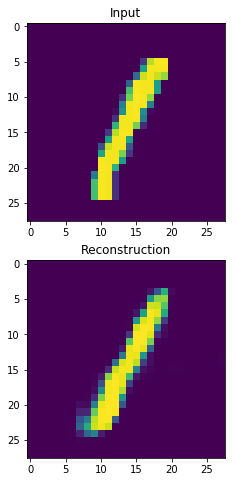

[[0.35763392]]
Reconstruction loss: 0.1767362
Discriminator Output: 0.35763392


In [11]:
test_reconstruction(1)

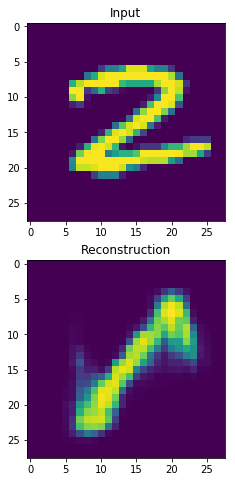

[[0.33657336]]
Reconstruction loss: 0.99789613
Discriminator Output: 0.33657336


In [12]:
test_reconstruction(2)

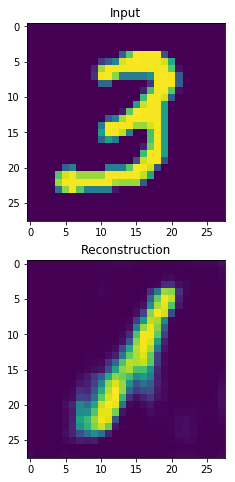

[[0.4066729]]
Reconstruction loss: 0.92308295
Discriminator Output: 0.4066729


In [13]:
test_reconstruction(3)

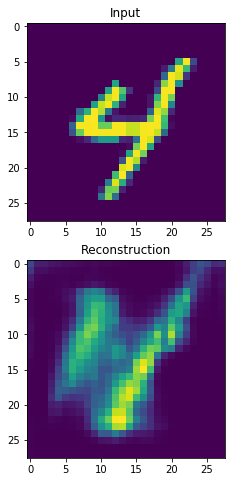

[[0.36911273]]
Reconstruction loss: 1.1340187
Discriminator Output: 0.36911273


In [14]:
test_reconstruction(4)

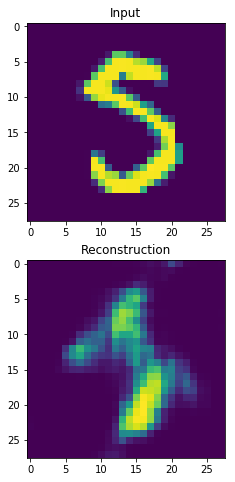

[[0.28173214]]
Reconstruction loss: 0.9502341
Discriminator Output: 0.28173214


In [15]:
test_reconstruction(5)

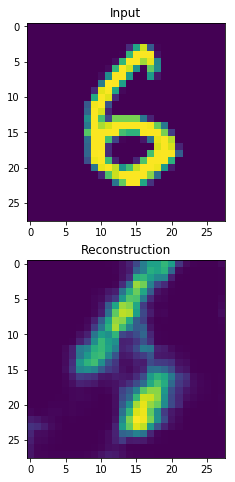

[[0.29842705]]
Reconstruction loss: 1.0341847
Discriminator Output: 0.29842705


In [16]:
test_reconstruction(6)

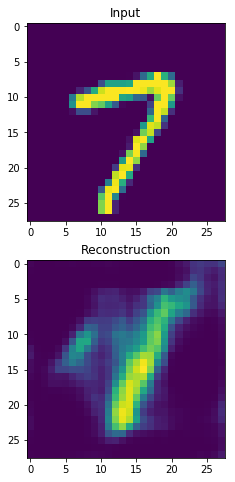

[[0.36824948]]
Reconstruction loss: 1.1271613
Discriminator Output: 0.36824948


In [17]:
test_reconstruction(7)

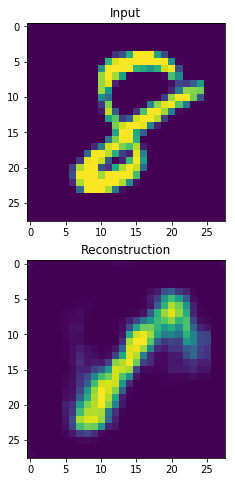

[[0.31330016]]
Reconstruction loss: 0.95027286
Discriminator Output: 0.31330016


In [18]:
test_reconstruction(8)

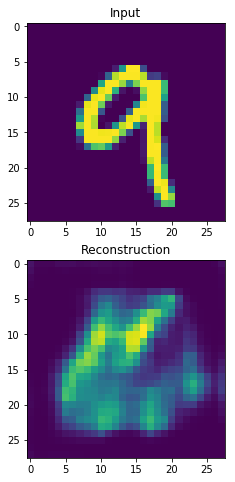

[[0.33294496]]
Reconstruction loss: 1.4965146
Discriminator Output: 0.33294496


In [19]:
test_reconstruction(9)

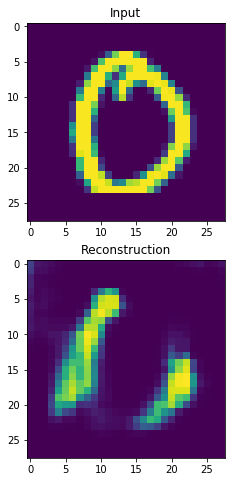

[[0.33245343]]
Reconstruction loss: 0.77030605
Discriminator Output: 0.33245343


In [20]:
test_reconstruction(0)